In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
import opencv_jupyter_ui as jcv2

from glob import glob

In [3]:
sys.path.append("/Users/jorgemarpa/MyStuff/repos/image_raw/")
from image_raw.align_images import *

In [4]:
path = "/Users/jorgemarpa/Pictures/Lightroom/edits/annular_eclipse_timelapse_2023"

In [5]:
f"{path}/batch_{batch_num:02}-*.jpg"

NameError: name 'batch_num' is not defined

In [6]:
batch_num = 5
img_files = sorted(glob(f"{path}/batch_{batch_num:02}-*.jpg"))
len(img_files)

410

# Using Circular Hough Transform

In [7]:
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage.draw import circle_perimeter
from tqdm import tqdm

  0%|          | 0/410 [00:00<?, ?it/s]

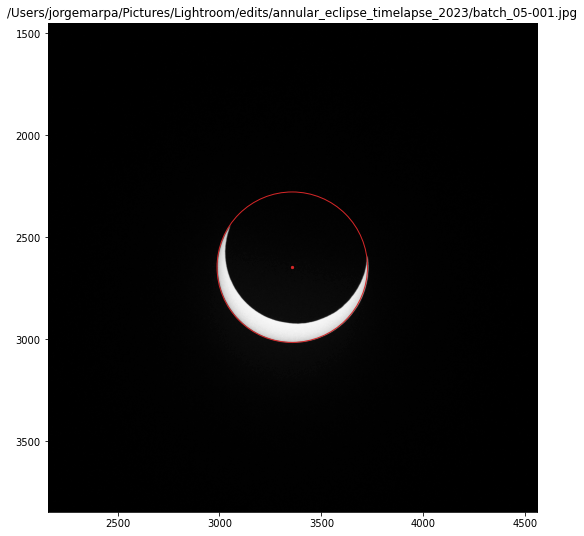

  2%|▏         | 10/410 [02:09<1:25:04, 12.76s/it]

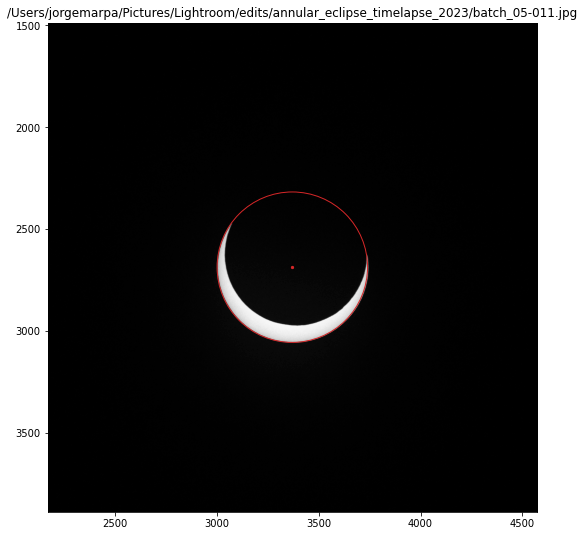

  5%|▍         | 20/410 [04:18<1:24:13, 12.96s/it]

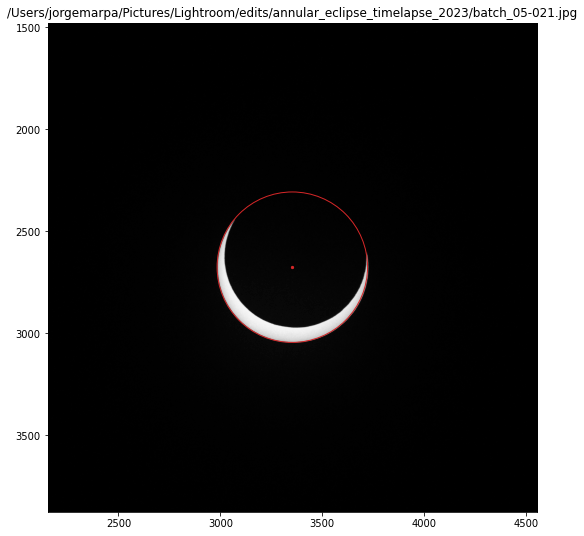

  6%|▋         | 26/410 [05:38<1:25:24, 13.34s/it]

In [8]:
sun_disk_rad = int(737 / 2)
stamp_size = 1200

results = []

for k, f in tqdm(enumerate(img_files), total=len(img_files)):
    img = cv2.imread(f)
    imgGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (H, W, C) = img.shape

    # detect edges
    edges = canny(imgGray, sigma=2, low_threshold=1, high_threshold=50)

    # plt.figure(figsize=(9, 9))
    # im = plt.imshow(edges.astype(int), vmin=0, vmax=0.01, interpolation="none")
    # plt.colorbar(im, shrink=0.5)
    # plt.xlim(3000, 5000)
    # plt.ylim(3500, 1500)
    # plt.show()

    # Detect several radii
    hough_radii = np.arange(sun_disk_rad - 5, sun_disk_rad + 5, 1)
    hough_res = hough_circle(edges, hough_radii)

    # Select the most prominent 3 circles
    accums, cx, cy, radii = hough_circle_peaks(
        hough_res, hough_radii, total_num_peaks=1
    )

    results.append([cx[0], cy[0], radii[0], stamp_size])

    if k % 10 == 0:
        fig, ax = plt.subplots(1, 1, figsize=(9, 9))
        ax.set_title(f)
        ax.imshow(
            imgGray,
            cmap="Greys_r",
        )
        ax.scatter(cx, cy, c="tab:red", marker="o", s=5)
        for x_c, y_c, rad in zip(cx, cy, radii):
            patch = plt.Circle((x_c, y_c), rad, color="tab:red", fill=False)
            ax.add_patch(patch)

        ax.set_xlim(cx[0] - stamp_size, cx[0] + stamp_size)
        ax.set_ylim(cy[0] + stamp_size, cy[0] - stamp_size)
        plt.show()

    Xedges = [cx[0] - stamp_size, cx[0] + stamp_size]
    Yedges = [cy[0] - stamp_size, cy[0] + stamp_size]

    if Xedges[0] > 0 and Xedges[1] < W and Yedges[0] > 0 and Yedges[1] < H:
        stamp = img[
            cy[0] - stamp_size : cy[0] + stamp_size,
            cx[0] - stamp_size : cx[0] + stamp_size,
        ]
    else:
        stamp = img[
            np.max(cy[0] - stamp_size, 0) : np.min(cy[0] + stamp_size, H),
            np.max(cx[0] - stamp_size, 0) : np.min(cx[0] + stamp_size, W),
        ]

        padleft = np.abs(Xedges[0])
        padright = np.abs(Xedges[1] - W)
        padtop = np.abs(Yedges[0])
        padbottom = np.abs(Yedges[1] - H)

        padded_image = cv2.copyMakeBorder(
            stamp, padtop, padbottom, padleft, padright, cv2.BORDER_CONSTANT, value=0
        )

    out_f = f"../data/stamps/{os.path.basename(f).replace('batch', 'stamp_batch')}"
    cv2.imwrite(out_f, stamp, [cv2.IMWRITE_JPEG_QUALITY, 100])

    # break

results = np.array(results)